# Library

In [15]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from gensim.models import Word2Vec

import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.keras

from sklearn.metrics import accuracy_score,f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Preprocessing

In [2]:
fnd_data_0=pd.read_csv('https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/3_WELFake_Embedding_workbase.csv')
fnd_data_0.head()

,label,message,message_clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general charlotte...
2,1,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raise hindu use story christian c...
3,0,SATAN 2: Russia unvelis an image of its terrif...,satan 2 russia unvelis image terrifying new su...
4,0,About Time! Christian Group Sues Amazon and SP...,time christian group sue amazon splc designati...


In [3]:
fnd_data=fnd_data_0.sample(10000)

In [4]:
fnd_data['label'].value_counts(normalize=True) * 100

label
1    54.51
0    45.49
Name: proportion, dtype: float64

In [5]:
sentences = fnd_data['message_clean'].tolist()
labels = fnd_data['label'].tolist()

In [6]:
# Entraîner le modèle Word2Vec
embedding_dim = 8  # Dimension des vecteurs Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [7]:
# Tokenizer Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts([" ".join(sentence) for sentence in sentences])
vocab_size = len(tokenizer.word_index) + 1

In [8]:
# Créer une matrice d'embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [9]:
# Définir la longueur maximale des séquences
max_length = max(len(sentence) for sentence in sentences)

# Modelling

In [10]:
# Préparer les données d'entraînement
X = tokenizer.texts_to_sequences([" ".join(sentence) for sentence in sentences])
X = pad_sequences(X, maxlen=100, padding='post')
y = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [11]:

# Définir le modèle Keras
base_model = tf.keras.Sequential([
    # Couche d'Input Word Embedding avec la matrice d'embedding pré-entraînée
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True, name="embedding"),
    # Couche LSTM
    tf.keras.layers.LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.01)),
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling1D(),
    # Couche Dense classique
    tf.keras.layers.Dense(64, activation='relu'),
    #Drop out pour prévenir de l'over-fitting
    tf.keras.layers.Dropout(0.5), 
    # Couche de sortie
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compilation du modèle
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        #tf.keras.metrics.Precision(),
        #tf.keras.metrics.Recall(),
        #tf.keras.metrics.AUC()
    ]
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-02-03 14:41:46.094056: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# Entraînement du modèle
history=base_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test))

Epoch 1/50


125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - binary_accuracy: 0.5355 - loss: 0.7400 - val_binary_accuracy: 0.6265 - val_loss: 0.6904
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.5665 - loss: 0.6859 - val_binary_accuracy: 0.6690 - val_loss: 0.6423
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.6497 - loss: 0.6498 - val_binary_accuracy: 0.6960 - val_loss: 0.6164
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.6910 - loss: 0.6100 - val_binary_accuracy: 0.6995 - val_loss: 0.5752
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - binary_accuracy: 0.7011 - loss: 0.5857 - val_binary_accuracy: 0.7160 - val_loss: 0.5641
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.6961 - loss: 0.5815 - val_binary_accuracy: 0.7160 - val_loss: 0.5578
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - binary_accuracy: 0.7097 - loss: 0.5679 - val_binary_accuracy: 0.7230 - val_loss: 0.5446
Epoch 8/50

## Check Metrics

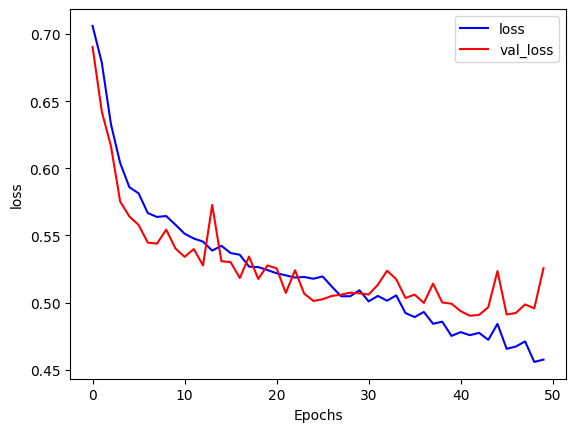

In [13]:
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='r', label='val_loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

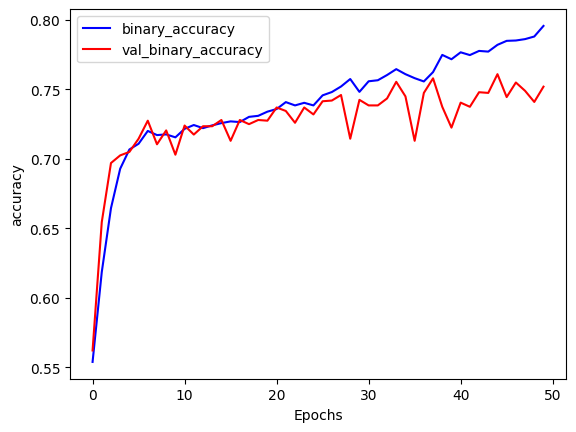

In [14]:
plt.plot(history.history['binary_accuracy'], color='b', label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], color='r', label='val_binary_accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [16]:
y_pred_proba = base_model.predict(X_test)  # Probabilités prédites
y_pred = (y_pred_proba > 0.5).astype("int32")  # Conversion en classes binaires (0 ou 1)

# Calcul du F1 score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1:.4f}")


 1/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
F1 Score: 0.7638


In [18]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de confusion :")
print(conf_matrix)

Matrice de confusion :
[[655 255]
 [259 831]]


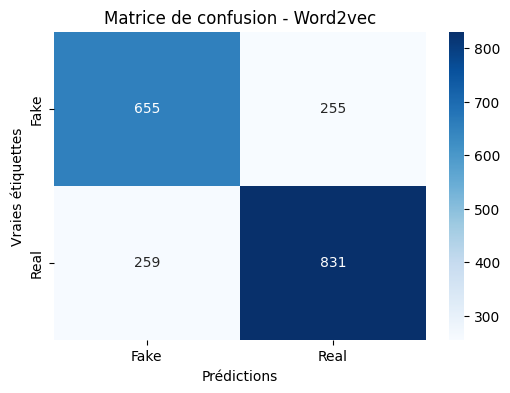

In [20]:
# Visualisation de la matrice de confusion avec Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion - Word2vec')
plt.show()

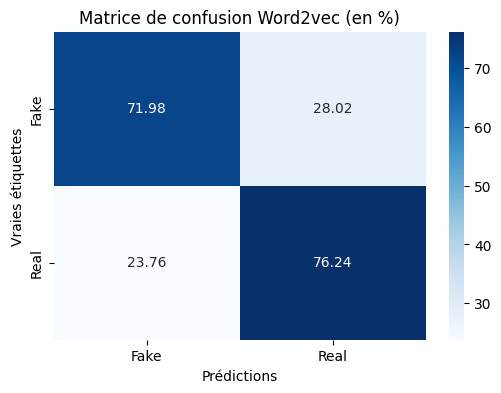

In [22]:
# Normalisation de la matrice de confusion en pourcentages
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Affichage de la matrice de confusion en pourcentages
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de confusion Word2vec (en %)')
plt.show()

# ML Flow - Log Model

In [15]:
# Configuration de MLflow
EXPERIMENT_NAME = "02_Fake News Detector - Word2vec Model"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# Activer l'autologging pour Keras
mlflow.keras.autolog()

# Démarrer une nouvelle run MLflow
with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Entraînement du modèle Word2Vec
    word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    
    # Création de la matrice d'embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    # Construction du modèle Keras
    base_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True, name="embedding"),
    tf.keras.layers.LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compilation du modèle
    base_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entraînement du modèle
    history = base_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test,y_test))

    # Évaluation du modèle
    y_pred = (base_model.predict(X_train) > 0.5).astype("int32")
    accuracy = accuracy_score(y_train, y_pred)

    # Affichage des résultats
    print("Modèle Word2Vec + Keras")
    print(f"Accuracy sur l'ensemble d'entraînement : {accuracy}")

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2025/01/29 14:03:33 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Failed to upload /tmp/tmpzcijuuj_/model_summary.txt to fnd-jedha-project/9/97b0dd8720024ba4806d301f4d094dc9/artifacts/model_summary.txt: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5564 - loss: 0.7359 - val_accuracy: 0.5615 - val_loss: 0.6770
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5950 - loss: 0.6711 - val_accuracy: 0.6280 - val_loss: 0.6527
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6621 - loss: 0.6298 - val_accuracy: 0.6940 - val_loss: 0.5981
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7018 - loss: 0.5886 - val_accuracy: 0.7150 - val_loss: 0.5660
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6986 - loss: 0.5777 - val_accuracy: 0.7175 - val_loss: 0.5509
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.7073 - loss: 0.5639 - val_accuracy: 0.7230 - val_loss: 0.5393
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7185 - loss: 0.5519 - val_accuracy: 0.7160 - val_loss: 0.5480
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7207 - loss: 0.5488 - val_accu

2025/01/29 14:05:56 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: All input schema' first dimension should be -1, which represents the dynamic batch dimension.


250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Modèle Word2Vec + Keras
Accuracy sur l'ensemble d'entraînement : 0.82875
🏃 View run upbeat-frog-236 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9/runs/97b0dd8720024ba4806d301f4d094dc9
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9
